In [1]:
!pip install mahotas==1.4.12 rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.9 MB/s eta 0:00:00
  Created wheel for mahotas: filename=mahotas-1.4.12-cp310-cp310-linux_x86_64.whl size=5248769 sha256=20b2517273c098e08b43f72a0cbc4f040bd9b99841d4456bb07371ea3147d523
  Stored in directory: /root/.cache/pip/wheels/34/80/d8/cc6f405e77ffdc00b02717814bf19d8d19340eea63a585a8d3
Successfully built mahotas


In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Colab Notebooks/smoke-plume-detection/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/IndustrialSmokePlumeDetection/segmentation')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/pytorch-deeplab-xception')

In [4]:
import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import argparse
from sklearn.metrics import jaccard_score

from data import create_dataset

import warnings
warnings.filterwarnings('ignore')

# prepare training and validation data loaders
data_all = create_dataset(
    datadir = '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/data', # /path/to/image/data/
    seglabeldir = '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/segmentation_labels', # /path/to/segmentation/labels/for/training/
    mult=1)

len_all = len(data_all)
split_1 = (15*len_all) // 100
split_2 = 2*split_1
indices = list(range(len_all))
random.seed(9001)
random.shuffle(indices)

test_sampler = SubsetRandomSampler(indices[:split_1])


<ipython-input-4-c7b6818629d0>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, RandomSampler
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

from network_ori import *
from model_unet import *

np.random.seed(3)
torch.manual_seed(3)

batch_size = 1 # 1 to create diagnostic images, any value otherwise
all_dl = DataLoader(data_all, batch_size=batch_size, sampler=test_sampler)
progress = tqdm(enumerate(all_dl), total=len(all_dl))

# load model
device = torch.device('cpu')

modelpaths={
    'u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/unet_ep300_lr3e-01_bs60_mo0.7_111.model',
    'r2u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2unet_ep300_lr5e-01_bs60_mo0.7_104.model',
    'attu-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/attunet_ep300_lr5e-01_bs60_mo0.7_116.model',
    'r2attu-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2attunet_ep300_lr5e-01_bs60_mo0.7_076.model',
    'dlabv3':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/dlabv3res_ep300_lr7e-01_bs60_mo0.7_147.model'
    }


# model = U_Net(img_ch=12, output_ch=1)
model = R2U_Net(img_ch=12, output_ch=1)


model.to(device)
model.load_state_dict(torch.load(
    '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2unet_ep300_lr5e-01_bs60_mo0.7_104.model', map_location=torch.device('cpu')))
model.eval()

# define loss function
loss_fn = nn.BCEWithLogitsLoss()

# run through test data
all_ious = []
all_accs = []
all_true = []
all_pred = []
all_arearatios = []
for i, batch in progress:
    x, y = batch['img'].float().to(device), batch['fpt'].float().to(device)
    idx = batch['idx']

    output = model(x)


    # obtain binary prediction map
    pred = np.zeros(output.shape)
    pred[output >= 0] = 1


    # derive Iou score
    cropped_iou = []
    for j in range(y.shape[0]):
        z = jaccard_score(y[j].flatten().detach().numpy(),
                          pred[j][0].flatten())
        if (np.sum(pred[j][0]) != 0 and
            np.sum(y[j].detach().numpy()) != 0):
            cropped_iou.append(z)

    all_ious = [*all_ious, *cropped_iou]
    
    # derive scalar binary labels on a per-image basis
    y_bin = np.array(np.sum(y.detach().numpy(),
                            axis=(1,2)) != 0).astype(int)
    prediction = np.array(np.sum(pred,
                               axis=(1,2,3)) != 0).astype(int)

    all_true.append(y_bin)
    all_pred.append(prediction)

 
    # derive image-wise accuracy for this batch
    all_accs.append(accuracy_score(y_bin, prediction))

    # derive binary segmentation map from prediction
    output_binary = np.zeros(output.shape)
    output_binary[output.cpu().detach().numpy() >= 0] = 1

    # derive smoke areas
    area_pred = np.sum(output_binary, axis=(1,2,3))
    area_true = np.sum(y.cpu().detach().numpy(), axis=(1,2))

    # derive smoke area ratios
    arearatios = []
    for k in range(len(area_pred)):
        if area_pred[k] == 0 and area_true[k] == 0:
            arearatios.append(1)
        elif area_true[k] == 0:
            arearatios.append(0)
        else:
            arearatios.append(area_pred[k]/area_true[k])
    all_arearatios = np.ravel([*all_arearatios, *arearatios])


    # if batch_size == 1:

    #     if prediction == 1 and y_bin == 1:
    #         res = 'true_pos'
    #     elif prediction == 0 and y_bin == 0:
    #         res = 'true_neg'
    #     elif prediction == 0 and y_bin == 1:
    #         res = 'false_neg'
    #     elif prediction == 1 and y_bin == 0:
    #         res = 'false_pos'

    #     # create plot
    #     f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(1, 3))

    #     # RGB plot
    #     ax1.imshow(0.2+1.5*(np.dstack([x[0][3], x[0][2], x[0][1]])-
    #                 np.min([x[0][3].numpy(),
    #                         x[0][2].numpy(),
    #                         x[0][1].numpy()]))/
    #                (np.max([x[0][3].numpy(),
    #                         x[0][2].numpy(),
    #                         x[0][1].numpy()])-
    #                 np.min([x[0][3].numpy(),
    #                         x[0][2].numpy(),
    #                         x[0][1].numpy()])),
    #                origin='upper')
    #     ax1.set_title({'true_pos': 'True Positive',
    #                    'true_neg': 'True Negative',
    #                    'false_pos': 'False Positive',
    #                    'false_neg': 'False Negative'}[res],
    #                   fontsize=8)
    #     ax1.set_xticks([])
    #     ax1.set_yticks([])

    #     # false color plot
    #     ax2.imshow(0.2+(np.dstack([x[0][0], x[0][9], x[0][10]])-
    #                 np.min([x[0][0].numpy(),
    #                         x[0][9].numpy(),
    #                         x[0][10].numpy()]))/
    #                (np.max([x[0][0].numpy(),
    #                         x[0][9].numpy(),
    #                         x[0][10].numpy()])-
    #                 np.min([x[0][0].numpy(),
    #                         x[0][9].numpy(),
    #                         x[0][10].numpy()])),
    #                origin='upper')

    #     ax2.set_xticks([])
    #     ax2.set_yticks([])

    #     # segmentation ground-truth and prediction
    #     ax3.imshow(y[0], cmap='Reds', alpha=0.3)
    #     ax3.imshow(pred[0][0], cmap='Greens', alpha=0.3)
    #     ax3.set_xticks([])
    #     ax3.set_yticks([])

    #     this_iou = jaccard_score(y[0].flatten().detach().numpy(),
    #                              pred[0][0].flatten())
    #     ax3.annotate("IoU={:.2f}".format(this_iou), xy=(5,15), fontsize=8)

    #     #segmentation probability distribution
       
    #     prob = torch.sigmoid(output)  #get the probability distribution
    #     ax4.imshow(prob[0][0].detach().numpy(), cmap = 'hot', vmin=0, vmax=1)
    #     ax4.set_xticks([])
    #     ax4.set_yticks([])
    #     ax4.annotate("Probability Map")
    #     # print(prob[0][0].size())
    #     ##

    #     f.subplots_adjust(0.05, 0.02, 0.95, 0.9, 0.05, 0.05)

    #     plt.savefig('./eval-results/unet111/'+res+(os.path.split(batch['imgfile'][0])[1]).\
    #                 replace('.tif', '_eval.png').replace(':', '_'),
    #                 tight_layout=True, dpi=200)
    #     plt.close()

print('iou:', len(all_ious), np.average(all_ious))
print('F1:', f1_score(all_true, all_pred))
print('accuracy:', len(all_accs), np.average(all_accs))
print('mean area ratio:', len(all_arearatios), np.average(all_arearatios),
      np.std(all_arearatios)/np.sqrt(len(all_arearatios)-1))

  0%|          | 0/428 [00:00<?, ?it/s]

iou: 199 0.5636663542081247
F1: 0.8984198645598194
accuracy: 428 0.8948598130841121
mean area ratio: 428 0.915582913231845 0.060315780277511874


#### Evaluation for only DL models

  0%|          | 0/428 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

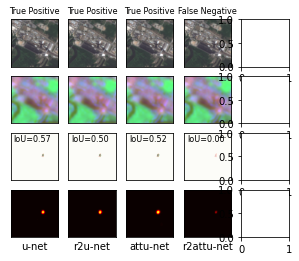

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, RandomSampler
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score

from network_ori import *
from model_unet import *
from modeling.deeplab import *

np.random.seed(3)
torch.manual_seed(3)

batch_size = 1 # 1 to create diagnostic images, any value otherwise
all_dl = DataLoader(data_all, batch_size=batch_size, sampler=test_sampler)
progress = tqdm(enumerate(all_dl), total=len(all_dl))

# load model
device = torch.device('cpu')

modelpaths={
    'u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/unet_ep300_lr3e-01_bs60_mo0.7_111.model',
    'r2u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2unet_ep300_lr5e-01_bs60_mo0.7_104.model',
    'attu-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/attunet_ep300_lr5e-01_bs60_mo0.7_116.model',
    'r2attu-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2attunet_ep300_lr5e-01_bs60_mo0.7_076.model',
    'dlabv3':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/dlabv3res_ep300_lr7e-01_bs60_mo0.7_147.model'
    }


models = {
    'u-net': U_Net(img_ch=12, output_ch=1),
    'r2u-net': R2U_Net(img_ch=12, output_ch=1),
    'attu-net': AttU_Net(img_ch=12, output_ch=1),
    'r2attu-net': R2AttU_Net(img_ch=12, output_ch=1),
    'dlabv3': DeepLab(num_classes=1, backbone='resnet')

}


for model in list(models.keys()):
    models[model].to(device)
    models[model].load_state_dict(torch.load(modelpaths[model],
                                                        map_location=device))
    models[model].eval()


# define loss function
loss_fn = nn.BCEWithLogitsLoss()

# run through test data



all_ious = {}
for model in list(models.keys()):
    all_ious[model] = []
all_accs = {}
for model in list(models.keys()):
    all_accs[model] = []
all_arearatios = {}
for model in list(models.keys()):
    all_arearatios[model] = []


for i, batch in progress:
    x, y = batch['img'].float().to(device), batch['fpt'].float().to(device)
    idx = batch['idx']

    output = {}
    pred = {}

    # create plot
    f, axs = plt.subplots(4, len(list(models.keys())), figsize=(5, 4))

    i = 0

    for model in list(models.keys()):
        output = models[model](x)

        # obtain binary prediction map
        pred = np.zeros(output.shape)
        pred[output>=0] =1

        # derive Iou score
        cropped_iou = []
        for j in range(y.shape[0]):
            z = jaccard_score(y[j].flatten().detach().numpy(),
                            pred[j][0].flatten())
            if (np.sum(pred[j][0]) != 0 and
                np.sum(y[j].detach().numpy()) != 0):
                cropped_iou.append(z)

        all_ious[model] = [*all_ious[model], *cropped_iou]

    
        # derive scalar binary labels on a per-image basis
        y_bin = np.array(np.sum(y.detach().numpy(),
                                axis=(1,2)) != 0).astype(int)
        prediction = np.array(np.sum(pred,
                                axis=(1,2,3)) != 0).astype(int)

        # derive image-wise accuracy for this batch
        all_accs[model].append(accuracy_score(y_bin, prediction))

        # derive binary segmentation map from prediction
        output_binary = np.zeros(output.shape)
        output_binary[output.cpu().detach().numpy() >= 0] = 1

        # derive smoke areas
        area_pred = np.sum(output_binary, axis=(1,2,3))
        area_true = np.sum(y.cpu().detach().numpy(), axis=(1,2))

        # derive smoke area ratios
        arearatios = []
        for k in range(len(area_pred)):
            if area_pred[k] == 0 and area_true[k] == 0:
                arearatios.append(1)
            elif area_true[k] == 0:
                arearatios.append(0)
            else:
                arearatios.append(area_pred[k]/area_true[k])
        all_arearatios[model] = np.ravel([*all_arearatios[model], *arearatios])


        if batch_size == 1:

            if prediction == 1 and y_bin == 1:
                res = 'true_pos'
            elif prediction == 0 and y_bin == 0:
                res = 'true_neg'
            elif prediction == 0 and y_bin == 1:
                res = 'false_neg'
            elif prediction == 1 and y_bin == 0:
                res = 'false_pos'


        # RGB plot
        axs[0,i].imshow(0.2+1.5*(np.dstack([x[0][3], x[0][2], x[0][1]])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()]))/
                   (np.max([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])),
                   origin='upper')
        axs[0,i].set_title({'true_pos': 'True Positive',
                       'true_neg': 'True Negative',
                       'false_pos': 'False Positive',
                       'false_neg': 'False Negative'}[res],
                      fontsize=8)
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        # false color plot
        axs[1,i].imshow(0.2+(np.dstack([x[0][0], x[0][9], x[0][10]])-
                    np.min([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()]))/
                   (np.max([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()])-
                    np.min([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()])),
                   origin='upper')

        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])

        # segmentation ground-truth and prediction
        axs[2,i].imshow(y[0], cmap='Reds', alpha=0.3)
        axs[2,i].imshow(pred[0][0], cmap='Greens', alpha=0.3)
        axs[2,i].set_xticks([])
        axs[2,i].set_yticks([])

        this_iou = jaccard_score(y[0].flatten().detach().numpy(),
                                 pred[0][0].flatten())
        axs[2,i].annotate("IoU={:.2f}".format(this_iou), xy=(5,15), fontsize=8)

        #segmentation probability distribution
       
        prob = torch.sigmoid(output)  #get the probability distribution
        axs[3,i].imshow(prob[0][0].detach().numpy(), cmap = 'hot', vmin=0, vmax=1)
        axs[3,i].set_xticks([])
        axs[3,i].set_yticks([])
        axs[3,i].set_xlabel(model)
        # axs[3,i].annotate("Probability@"+ model, xy=(5,15))
        # print(prob[0][0].size())
        ##
        i+=1

    # f.subplots_adjust(0.05, 0.02, 0.95, 0.9, 0.05, 0.05)

    plt.savefig('./eval-results/union/'+res+(os.path.split(batch['imgfile'][0])[1]).\
                replace('.tif', '_eval.png').replace(':', '_'),
                tight_layout=True, dpi=200)
    plt.close()

# print('iou:', len(all_ious), np.average(all_ious))
# print('accuracy:', len(all_accs), np.average(all_accs))
# print('mean area ratio:', len(all_arearatios), np.average(all_arearatios),
#       np.std(all_arearatios)/np.sqrt(len(all_arearatios)-1))

In [ ]:
# load model
device = torch.device('cpu')

modelpaths={
    'u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/unet_ep300_lr3e-01_bs60_mo0.7_111.model',
    'r2u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2unet_ep300_lr5e-01_bs60_mo0.7_104.model',
    'attu-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/attunet_ep300_lr5e-01_bs60_mo0.7_116.model'
    }


models = {
    'u-net': U_Net(img_ch=12, output_ch=1),
    'r2u-net': R2U_Net(img_ch=12, output_ch=1),
    'attu-net': AttU_Net(img_ch=12, output_ch=1)

}


for model in list(models.keys()):
    models[model].to(device)
    models[model].load_state_dict(torch.load(modelpaths[model],
                                                        map_location=device))
    models[model].eval()


#### Evaluation for DL + ML models

##### ML functions

In [ ]:
!pip install numpy --upgrade && pip install mahotas

In [ ]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/IndustrialSmokePlumeDetection/segmentation')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/pytorch-deeplab-xception')

In [ ]:
import cv2
import numpy as np
import pylab as plt
from glob import glob
import argparse
import os
import progressbar
import pickle as pkl
from numpy.lib import stride_tricks
from skimage import feature
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time
import mahotas as mt

def check_args(args):

    if not os.path.exists(args.image_dir):
        raise ValueError("Image directory does not exist")

    if not os.path.exists(args.label_dir):
        raise ValueError("Label directory does not exist")

    if args.classifier != "SVM" and args.classifier != "RF" and args.classifier != "GBC":
        raise ValueError("Classifier must be either SVM, RF or GBC")

    if args.output_model.split('.')[-1] != "p":
        raise ValueError("Model extension must be .p")

    return args

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--image_dir" , help="Path to images", required=True)
    parser.add_argument("-l", "--label_dir", help="Path to labels", required=True)
    parser.add_argument("-c", "--classifier", help="Classification model to use", required = True)
    parser.add_argument("-o", "--output_model", help="Path to save model. Must end in .p", required = True)
    args = parser.parse_args()
    return check_args(args)

def read_data(image_dir, label_dir):

    print ('[INFO] Reading image data.')

    filelist = glob(os.path.join(image_dir, '*.jpg'))
    image_list = []
    label_list = []

    for file in filelist:

        image_list.append(cv2.imread(file, 1))
        label_list.append(cv2.imread(os.path.join(label_dir, os.path.basename(file).split('.')[0]+'.png'), 0))

    return image_list, label_list

def subsample(features, labels, low, high, sample_size):

    idx = np.random.randint(low, high, sample_size)

    return features[idx], labels[idx]

def subsample_idx(low, high, sample_size):

    return np.random.randint(low,high,sample_size)

def calc_haralick(roi):

    feature_vec = []

    texture_features = mt.features.haralick(roi)
    mean_ht = texture_features.mean(axis=0)

    [feature_vec.append(i) for i in mean_ht[0:9]]

    return np.array(feature_vec)

def harlick_features(img, h_neigh, ss_idx):

    print ('[INFO] Computing haralick features.')
    size = h_neigh
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    strides = 2 * img.strides
    patches = stride_tricks.as_strided(img, shape=shape, strides=strides)
    patches = patches.reshape(-1, size, size)

    if len(ss_idx) == 0 :
        bar = progressbar.ProgressBar(maxval=len(patches), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    else:
        bar = progressbar.ProgressBar(maxval=len(ss_idx), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    bar.start()

    h_features = []

    if len(ss_idx) == 0:
        for i, p in enumerate(patches):
            bar.update(i+1)
            h_features.append(calc_haralick(p))
    else:
        for i, p in enumerate(patches[ss_idx]):
            bar.update(i+1)
            h_features.append(calc_haralick(p))

    #h_features = [calc_haralick(p) for p in patches[ss_idx]]

    return np.array(h_features)

def create_binary_pattern(img, p, r):

    print ('[INFO] Computing local binary pattern features.')
    lbp = feature.local_binary_pattern(img, p, r)
    return (lbp-np.min(lbp))/(np.max(lbp)-np.min(lbp)) * 255

def create_features(img, img_gray, label, train=True):

    lbp_radius = 24 # local binary pattern neighbourhood
    h_neigh = 11 # haralick neighbourhood
    num_examples = 100 # number of examples per image to use for training model

    lbp_points = lbp_radius*8
    h_ind = int((h_neigh - 1)/ 2)

    feature_img = np.zeros((img.shape[0],img.shape[1],13))
    feature_img[:,:,:12] = img
    img = None
    feature_img[:,:,12] = create_binary_pattern(img_gray, lbp_points, lbp_radius)
    feature_img = feature_img[h_ind:-h_ind, h_ind:-h_ind]
    features = feature_img.reshape(feature_img.shape[0]*feature_img.shape[1], feature_img.shape[2])

    if train == True:
        ss_idx = subsample_idx(0, features.shape[0], num_examples)
        features = features[ss_idx]
    else:
        ss_idx = []

    h_features = harlick_features(img_gray, h_neigh, ss_idx)
    features = np.hstack((features, h_features))

    if train == True:

        label = label[h_ind:-h_ind, h_ind:-h_ind]
        labels = label.reshape(label.shape[0]*label.shape[1], 1)
        labels = labels[ss_idx]
    else:
        labels = None

    return features, labels

def get_int_rgb(np_img):
    rgb_img =  (np.dstack([np_img[3], np_img[2], np_img[1]])-
                        np.min([np_img[3],
                                np_img[2],
                                np_img[1]]))/ \
                    (np.max([np_img[3],
                                np_img[2],
                                np_img[1]])-
                        np.min([np_img[3],
                                np_img[2],
                                np_img[1]]))
    rgb_img = (rgb_img * 255).round().astype(np.uint8)
    full_img = np.moveaxis(np_img,0,-1)
    return rgb_img, full_img
    

def create_training_dataset(image_list, label_list):

    print ('[INFO] Creating training dataset on %d image(s).' %len(image_list))

    X = []
    y = []

    for i, img in enumerate(image_list):
        
        rgb_img, full_img = get_int_rgb(img)
        img_gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
        features, labels = create_features(full_img, img_gray, label_list[i])
        X.append(features)
        y.append(labels)

    X = np.array(X)
    X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
    y = np.array(y)
    y = y.reshape(y.shape[0]*y.shape[1], y.shape[2]).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print ('[INFO] Feature vector size:', X_train.shape)

    return X_train, X_test, y_train, y_test

def train_model(X, y, classifier):

    if classifier == "SVM":
        from sklearn.svm import SVC
        print ('[INFO] Training Support Vector Machine model.')
        model = SVC()
        model.fit(X, y)
    elif classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        print ('[INFO] Training Random Forest model.')
        model = RandomForestClassifier(n_estimators=250, max_depth=12, random_state=42)
        model.fit(X, y)
    elif classifier == "GBC":
        from sklearn.ensemble import GradientBoostingClassifier
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
        model.fit(X, y)

    print ('[INFO] Model training complete.')
    print ('[INFO] Training Accuracy: %.2f' %model.score(X, y))
    return model

def test_model(X, y, model):

    pred = model.predict(X)
    precision = metrics.precision_score(y, pred, average='weighted', labels=np.unique(pred))
    recall = metrics.recall_score(y, pred, average='weighted', labels=np.unique(pred))
    f1 = metrics.f1_score(y, pred, average='weighted', labels=np.unique(pred))
    accuracy = metrics.accuracy_score(y, pred)

    print ('--------------------------------')
    print ('[RESULTS] Accuracy: %.2f' %accuracy)
    print ('[RESULTS] Precision: %.2f' %precision)
    print ('[RESULTS] Recall: %.2f' %recall)
    print ('[RESULTS] F1: %.2f' %f1)
    print ('--------------------------------')

In [ ]:
import cv2
import numpy as np
import pylab as plt
from glob import glob
import argparse
import os
import pickle as pkl
import math

def check_args(args):

    if not os.path.exists(args.image_dir):
        raise ValueError("Image directory does not exist")

    if not os.path.exists(args.output_dir):
        raise ValueError("Output directory does not exist")

    return args

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--image_dir" , help="Path to images", required=True)
    parser.add_argument("-m", "--model_path", help="Path to .p model", required=True)
    parser.add_argument("-o", "--output_dir", help="Path to output directory", required = True)
    args = parser.parse_args()
    return check_args(args)

def infer_create_features(img):
    
    rgb_img, full_img = get_int_rgb(img)

    img_gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

    features, _ = create_features(full_img, img_gray, label=None, train=False)

    return features

def compute_prediction(img, model):

    border = 5 # (haralick neighbourhood - 1) / 2
    
    full_img = np.moveaxis(img,0,-1)
    

    full_img = cv2.copyMakeBorder(full_img, top=border, bottom=border, \
                                  left=border, right=border, \
                                  borderType = cv2.BORDER_CONSTANT, \
                                  value=[0]*3)
    
    img = np.moveaxis(full_img,-1,0)

    features = infer_create_features(img)
    predictions = model.predict(features.reshape(-1, features.shape[1]))
    pred_size = int(math.sqrt(features.shape[0]))
    inference_img = predictions.reshape(pred_size, pred_size)
    print(inference_img.shape)

    return inference_img

def compute_prediction_prob(img, model):

    border = 5 # (haralick neighbourhood - 1) / 2
    
    full_img = np.moveaxis(img,0,-1)
    

    full_img = cv2.copyMakeBorder(full_img, top=border, bottom=border, \
                                  left=border, right=border, \
                                  borderType = cv2.BORDER_CONSTANT, \
                                  value=[0]*3)
    
    img = np.moveaxis(full_img,-1,0)

    features = infer_create_features(img)
    predictions = model.predict(features.reshape(-1, features.shape[1]))
    predictions_prob = model.predict_proba(features.reshape(-1, features.shape[1]))
#     print(predictions.shape)
    pred_size = int(math.sqrt(features.shape[0]))
    inference_img = predictions.reshape(pred_size, pred_size)
    prob_img = predictions_prob[:,1].reshape(pred_size, pred_size)
#     print(inference_img.shape)

    return inference_img, prob_img

def infer_images(image_dir, model_path, output_dir):

    filelist = glob(os.path.join(image_dir,'*.jpg'))

    print ('[INFO] Running inference on %s test images' %len(filelist))

    model = pkl.load(open( model_path, "rb" ) )

    for file in filelist:
        print ('[INFO] Processing images:', os.path.basename(file))
        inference_img = compute_prediction(cv2.imread(file, 1), model)
        cv2.imwrite(os.path.join(output_dir, os.path.basename(file)), inference_img)

##### Data Loader

In [ ]:
import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import argparse
from sklearn.metrics import jaccard_score

from data import create_dataset

import warnings
warnings.filterwarnings('ignore')

# prepare training and validation data loaders
data_all = create_dataset(
    datadir = '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/data', # /path/to/image/data/
    seglabeldir = '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/segmentation_labels', # /path/to/segmentation/labels/for/training/
    mult=1)

len_all = len(data_all)
split_1 = (15*len_all) // 100
split_2 = 2*split_1
indices = list(range(len_all))
random.seed(9001)
random.shuffle(indices)

test_sampler = SubsetRandomSampler(indices[:split_1])


##### Plots

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, RandomSampler
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score

from network_ori import *
from model_unet import *
from modeling.deeplab import *

np.random.seed(3)
torch.manual_seed(3)

batch_size = 1 # 1 to create diagnostic images, any value otherwise
all_dl = DataLoader(data_all, batch_size=batch_size, sampler=test_sampler)
progress = tqdm(enumerate(all_dl), total=len(all_dl))

# load model
device = torch.device('cpu')

modelpaths={
    'u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/unet_ep300_lr3e-01_bs60_mo0.7_111.model',
    'r2u-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2unet_ep300_lr5e-01_bs60_mo0.7_104.model',
    'attu-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/attunet_ep300_lr5e-01_bs60_mo0.7_116.model',
    'r2attu-net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2attunet_ep300_lr5e-01_bs60_mo0.7_076.model',
    'dlabv3':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/dlabv3res_ep300_lr7e-01_bs60_mo0.7_147.model',
    # 'svm': '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/svm.p',
    'rf': '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/rf.p',
    # 'gbc':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/gbc.p'
    }


models = {
    'u-net': U_Net(img_ch=12, output_ch=1),
    'r2u-net': R2U_Net(img_ch=12, output_ch=1),
    'attu-net': AttU_Net(img_ch=12, output_ch=1),
    'r2attu-net': R2AttU_Net(img_ch=12, output_ch=1),
    'dlabv3': DeepLab(num_classes=1, backbone='resnet')

}

ml_models = {
    # 'svm': pkl.load(open(modelpaths['svm'], "rb" )),
    'rf': pkl.load(open(modelpaths['rf'],"rb")),
    # 'gbc':pkl.load(open(modelpaths['gbc'],"rb"))
}


for model in list(models.keys()):
    models[model].to(device)
    models[model].load_state_dict(torch.load(modelpaths[model],
                                                        map_location=device))
    models[model].eval()


# define loss function
loss_fn = nn.BCEWithLogitsLoss()

# run through test data



all_ious = {}
for model in list(models.keys()):
    all_ious[model] = []
all_accs = {}
for model in list(models.keys()):
    all_accs[model] = []
all_arearatios = {}
for model in list(models.keys()):
    all_arearatios[model] = []


for i, batch in progress:
    x, y = batch['img'].float().to(device), batch['fpt'].float().to(device)
    idx = batch['idx']

    output = {}
    pred = {}

    # create plot
    f, axs = plt.subplots(4, 6, figsize=(6, 4))

    i = 0

    for model in list(models.keys()):
        output = models[model](x)

        # obtain binary prediction map
        pred = np.zeros(output.shape)
        pred[output>=0] =1

        # derive Iou score
        cropped_iou = []
        for j in range(y.shape[0]):
            z = jaccard_score(y[j].flatten().detach().numpy(),
                            pred[j][0].flatten())
            if (np.sum(pred[j][0]) != 0 and
                np.sum(y[j].detach().numpy()) != 0):
                cropped_iou.append(z)

        all_ious[model] = [*all_ious[model], *cropped_iou]

    
        # derive scalar binary labels on a per-image basis
        y_bin = np.array(np.sum(y.detach().numpy(),
                                axis=(1,2)) != 0).astype(int)
        prediction = np.array(np.sum(pred,
                                axis=(1,2,3)) != 0).astype(int)

        # derive image-wise accuracy for this batch
        all_accs[model].append(accuracy_score(y_bin, prediction))

        # derive binary segmentation map from prediction
        output_binary = np.zeros(output.shape)
        output_binary[output.cpu().detach().numpy() >= 0] = 1

        # derive smoke areas
        area_pred = np.sum(output_binary, axis=(1,2,3))
        area_true = np.sum(y.cpu().detach().numpy(), axis=(1,2))

        # derive smoke area ratios
        arearatios = []
        for k in range(len(area_pred)):
            if area_pred[k] == 0 and area_true[k] == 0:
                arearatios.append(1)
            elif area_true[k] == 0:
                arearatios.append(0)
            else:
                arearatios.append(area_pred[k]/area_true[k])
        all_arearatios[model] = np.ravel([*all_arearatios[model], *arearatios])


        if batch_size == 1:

            if prediction == 1 and y_bin == 1:
                res = 'true_pos'
            elif prediction == 0 and y_bin == 0:
                res = 'true_neg'
            elif prediction == 0 and y_bin == 1:
                res = 'false_neg'
            elif prediction == 1 and y_bin == 0:
                res = 'false_pos'


        # RGB plot
        axs[0,i].imshow(0.2+1.5*(np.dstack([x[0][3], x[0][2], x[0][1]])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()]))/
                   (np.max([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])),
                   origin='upper')
        axs[0,i].set_title({'true_pos': 'True Positive',
                       'true_neg': 'True Negative',
                       'false_pos': 'False Positive',
                       'false_neg': 'False Negative'}[res],
                      fontsize=8)
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        # false color plot
        axs[1,i].imshow(0.2+(np.dstack([x[0][0], x[0][9], x[0][10]])-
                    np.min([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()]))/
                   (np.max([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()])-
                    np.min([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()])),
                   origin='upper')

        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])

        # segmentation ground-truth and prediction
        axs[2,i].imshow(y[0], cmap='Reds', alpha=0.3)
        axs[2,i].imshow(pred[0][0], cmap='Greens', alpha=0.3)
        axs[2,i].set_xticks([])
        axs[2,i].set_yticks([])

        this_iou = jaccard_score(y[0].flatten().detach().numpy(),
                                 pred[0][0].flatten())
        axs[2,i].annotate("IoU={:.2f}".format(this_iou), xy=(5,15), fontsize=8)

        #segmentation probability distribution
       
        prob = torch.sigmoid(output)  #get the probability distribution
        axs[3,i].imshow(prob[0][0].detach().numpy(), cmap = 'hot', vmin=0, vmax=1)
        axs[3,i].set_xticks([])
        axs[3,i].set_yticks([])
        axs[3,i].set_xlabel(model)
        # axs[3,i].annotate("Probability@"+ model, xy=(5,15))
        # print(prob[0][0].size())
        ##
        i+=1

    for model in ml_models.keys():

         # RGB plot
        axs[0,i].imshow(0.2+1.5*(np.dstack([x[0][3], x[0][2], x[0][1]])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()]))/
                   (np.max([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])),
                   origin='upper')
        axs[0,i].set_title({'true_pos': 'True Positive',
                       'true_neg': 'True Negative',
                       'false_pos': 'False Positive',
                       'false_neg': 'False Negative'}[res],
                      fontsize=8)
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        # false color plot
        axs[1,i].imshow(0.2+(np.dstack([x[0][0], x[0][9], x[0][10]])-
                    np.min([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()]))/
                   (np.max([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()])-
                    np.min([x[0][0].numpy(),
                            x[0][9].numpy(),
                            x[0][10].numpy()])),
                   origin='upper')

        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])


        # segmentation ground-truth and prediction

        pred, prob = compute_prediction_prob(x[0].numpy(), ml_models[model])

        axs[2,i].imshow(y[0], cmap='Reds', alpha=0.3)
        axs[2,i].imshow(pred, cmap='Greens', alpha=0.3)
        axs[2,i].set_xticks([])
        axs[2,i].set_yticks([])

        this_iou = jaccard_score(y[0].flatten().detach().numpy(),
                                 pred.flatten())
        axs[2,i].annotate("IoU={:.2f}".format(this_iou), xy=(5,15), fontsize=8)

        #prob
        axs[3,i].imshow(prob, cmap='hot', vmin=0, vmax=1)
        axs[3,i].set_xticks([])
        axs[3,i].set_yticks([])
        axs[3,i].set_xlabel(model)

        i+=1


    # f.subplots_adjust(0.05, 0.02, 0.95, 0.9, 0.05, 0.05)

    plt.savefig('./eval-results/union/'+res+(os.path.split(batch['imgfile'][0])[1]).\
                replace('.tif', '_eval.png').replace(':', '_'),
                tight_layout=True, dpi=200)
    plt.close()

# print('iou:', len(all_ious), np.average(all_ious))
# print('accuracy:', len(all_accs), np.average(all_accs))
# print('mean area ratio:', len(all_arearatios), np.average(all_arearatios),
#       np.std(all_arearatios)/np.sqrt(len(all_arearatios)-1))

##### paper-ready

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, RandomSampler
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score

from network_ori import *
from model_unet import *
from modeling.deeplab import *

np.random.seed(3)
torch.manual_seed(3)

batch_size = 1 # 1 to create diagnostic images, any value otherwise
all_dl = DataLoader(data_all, batch_size=batch_size, sampler=test_sampler)
progress = tqdm(enumerate(all_dl), total=len(all_dl))

# load model
device = torch.device('cpu')

wanted = ['212846_2019-03-02T11_08_59.015Z_6_eval.png', '74662_2019-12-05T10_16_17.136Z_40_eval.png', '46361_2019-10-06T10_16_24.037Z_12_eval.png',
          '46361_2019-06-23T10_16_27.346Z_7_eval.png', '11173_2019-04-23T10_02_53.879Z_0_eval.png', '10362_2019-12-10T10_16_43.686Z_0_eval.png', 
          '6594_2019-03-03T10_28_32.286Z_3_eval.png', '198_2019-06-30T10_06_44.463Z_22_eval.png']
# wanted = wanted[:2]

wanted = ['74662_2019-12-05T10_16_17.136Z_40_eval.png', '46361_2019-06-23T10_16_27.346Z_7_eval.png', '10362_2019-12-10T10_16_43.686Z_0_eval.png', 
          '6594_2019-03-03T10_28_32.286Z_3_eval.png']

modelpaths={
    'U-Net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/unet_ep300_lr3e-01_bs60_mo0.7_111.model',
    'R2U-Net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2unet_ep300_lr5e-01_bs60_mo0.7_104.model',
    'AttU-Net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/attunet_ep300_lr5e-01_bs60_mo0.7_116.model',
    # 'R2AttU-Net':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/r2attunet_ep300_lr5e-01_bs60_mo0.7_076.model',
    'DLabv3+':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/dlabv3res_ep300_lr7e-01_bs60_mo0.7_147.model',
    # 'SVM': '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/svm.p',
    'RF': '/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/rf.p',
    # 'GBC':'/content/drive/MyDrive/Colab Notebooks/smoke-plume-detection/models/gbc.p'
    }


models = {
    'U-Net': U_Net(img_ch=12, output_ch=1),
    'R2U-Net': R2U_Net(img_ch=12, output_ch=1),
    'AttU-Net': AttU_Net(img_ch=12, output_ch=1),
    # 'R2AttU-Net': R2AttU_Net(img_ch=12, output_ch=1),
    'DLabv3+': DeepLab(num_classes=1, backbone='resnet')

}

ml_models = {
    # 'SVM': pkl.load(open(modelpaths['SVM'], "rb" )),
    'RF': pkl.load(open(modelpaths['RF'],"rb")),
    # 'GBC':pkl.load(open(modelpaths['GBC'],"rb"))
}


for model in list(models.keys()):
    models[model].to(device)
    models[model].load_state_dict(torch.load(modelpaths[model],
                                                        map_location=device))
    models[model].eval()


# define loss function
loss_fn = nn.BCEWithLogitsLoss()

# run through test data



all_ious = {}
for model in list(models.keys()):
    all_ious[model] = []
all_accs = {}
for model in list(models.keys()):
    all_accs[model] = []
all_arearatios = {}
for model in list(models.keys()):
    all_arearatios[model] = []


count = 0

# create plot
f, axs = plt.subplots(len(wanted), 7, figsize=(7, len(wanted)))



i = 0 
for k, batch in progress:
    x, y = batch['img'].float().to(device), batch['fpt'].float().to(device)
    idx = batch['idx']

    output = {}
    pred = {}

    imgname = (os.path.split(batch['imgfile'][0])[1]).replace('.tif', '_eval.png').replace(':', '_')
    if imgname in wanted and count<len(wanted):

        # RGB plot
        axs[i,0].imshow(0.2+1.5*(np.dstack([x[0][3], x[0][2], x[0][1]])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()]))/
                (np.max([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])-
                    np.min([x[0][3].numpy(),
                            x[0][2].numpy(),
                            x[0][1].numpy()])),
                origin='upper')
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
        if i == len(wanted)-1:
            axs[i,0].set_xlabel('RGB')
        
        # Ground truth
        axs[i,1].imshow(y[0], cmap='Reds', alpha=0.3)
        axs[i,1].set_xticks([])
        axs[i,1].set_yticks([])
        if i == len(wanted)-1:
            axs[i,1].set_xlabel('Gound-truth')

        j = 2
        for model in list(models.keys()):
            
            output = models[model](x)

            # obtain binary prediction map
            pred = np.zeros(output.shape)
            pred[output>=0] =1

            
             # derive scalar binary labels on a per-image basis
            y_bin = np.array(np.sum(y.detach().numpy(),
                                    axis=(1,2)) != 0).astype(int)
            prediction = np.array(np.sum(pred,
                                    axis=(1,2,3)) != 0).astype(int)
            
            if batch_size == 1:

                if prediction == 1 and y_bin == 1:
                    res = '++'
                elif prediction == 0 and y_bin == 0:
                    res = '+-'
                elif prediction == 0 and y_bin == 1:
                    res = '--'
                elif prediction == 1 and y_bin == 0:
                    res = '-+'
            
            #prob plot
       
            prob = torch.sigmoid(output)  #get the probability distribution
            this_iou = jaccard_score(y[0].flatten().detach().numpy(),
                                    pred[0][0].flatten())
            
            axs[i,j].imshow(prob[0][0].detach().numpy(), cmap = 'hot', vmin=0, vmax=1)
            axs[i,j].text(5,15, res+"IoU={:.2f}".format(this_iou), fontsize=6, color='white')
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

            if i == len(wanted)-1:
               axs[i,j].set_xlabel(model)

            j+=1

        
        for model in ml_models.keys():
            
            pred, prob = compute_prediction_prob(x[0].numpy(), ml_models[model])
            this_iou = jaccard_score(y[0].flatten().detach().numpy(),
                                 pred.flatten())
            
            # derive scalar binary labels on a per-image basis
            y_bin = np.array(np.sum(y.detach().numpy(),
                                    axis=(1,2)) != 0).astype(int)
            prediction = np.array(np.sum(pred,
                                    axis=(0,1)) != 0).astype(int)

            if batch_size == 1:

                if prediction == 1 and y_bin == 1:
                    res = '++'
                elif prediction == 0 and y_bin == 0:
                    res = '+-'
                elif prediction == 0 and y_bin == 1:
                    res = '--'
                elif prediction == 1 and y_bin == 0:
                    res = '-+'

            #prob plot
            im = axs[i,j].imshow(prob, cmap='hot', vmin=0, vmax=1) #im for colorbar
            axs[i,j].text(5,15,res+"IoU={:.2f}".format(this_iou), fontsize=6, color='white')
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

            if i == len(wanted)-1:
               axs[i,j].set_xlabel(model)
            
            j+=1

        
        if i == len(wanted)-1:
            print('Saving the plot...')
            f.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom = 0.1, wspace=0.05, hspace=0.05)
            cb_ax = f.add_axes([0.87, 0.1, 0.06, 0.8])
            cbar = f.colorbar(im, cax=cb_ax)
            plt.savefig('./eval-results/paper-ready/results.png', tight_layout=True, dpi=800)
            plt.close()
            print('Plot saved..')

        i+=1

    continue


  0%|          | 0/428 [00:00<?, ?it/s]

[                                                                        ] N/A%

[INFO] Computing local binary pattern features.
[INFO] Computing haralick features.


[========================================================================] 100%WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[                                                                        ] N/A%

[INFO] Computing local binary pattern features.
[INFO] Computing haralick features.


[========================================================================] 100%WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[                                                                        ] N/A%

[INFO] Computing local binary pattern features.
[INFO] Computing haralick features.


[========================================================================] 100%WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[                                                                        ] N/A%

[INFO] Computing local binary pattern features.
[INFO] Computing haralick features.


[========================================================================] 100%

Saving the plot...
Plot saved..


KeyboardInterrupt: ignored

In [ ]:
!ls

data				    README.md
dl-eval.ipynb			    runs
ep300_lr7e-01_bs60_mo0.7_000.model  segmentation_labels
eval-results			    segmentation_labels.tar.gz
images.tar.gz			    smoke-ml-bal.ipynb
IndustrialSmokePlumeDetection	    smoke-plume-detection.ipynb
models				    test_labels
pytorch-deeplab-xception	    test.tif
pytorch-deeplab-xception-bacup


In [ ]:
import matplotlib.pyplot as plt

device = torch.device('cpu')

batch_size = 1 # 1 to create diagnostic images, any value otherwise
all_dl = DataLoader(data_all, batch_size=batch_size, sampler=test_sampler)
progress = tqdm(enumerate(all_dl), total=len(all_dl))

for i, batch in progress:
    x = batch['img'].float().to(device)
    y = batch['fpt'].float().to(device)

    for j in range(x.shape[0]):
        # create plot
        f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(1, 3))

        # RGB
        img =  (np.dstack([x[j][3], x[j][2], x[j][1]])-
                        np.min([x[j][3].numpy(),
                                x[j][2].numpy(),
                                x[j][1].numpy()]))/ \
                    (np.max([x[j][3].numpy(),
                                x[j][2].numpy(),
                                x[j][1].numpy()])-
                        np.min([x[j][3].numpy(),
                                x[j][2].numpy(),
                                x[j][1].numpy()]))
        ax1.imshow(0.2+1.5*img) # more brighten
        ax1.set_xticks([])
        ax1.set_yticks([])
        
        

        #ground-truth and pred
        ax2.imshow(y[j], cmap='Reds', alpha=0.3)
        ax2.imshow(compute_prediction((img * 255).round().astype(np.uint8), model), cmap='Greens', alpha=0.3)
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        #only ground-truth
        ax3.imshow(y[j], cmap='Reds', alpha=0.3)
        ax3.set_xticks([])
        ax3.set_yticks([])
        
        
        f.subplots_adjust(0.05, 0.02, 0.95, 0.9, 0.05, 0.05)

        plt.show()


In [ ]:
!ls

drive  sample_data


In [ ]:
random.seed(10)
l = list(range(10))
random.shuffle(l)
print(l)

[5, 2, 7, 1, 8, 4, 3, 6, 0, 9]
